In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import

In [2]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.9-py3-none-any.whl size=184112 sha256=9119be7b94c2be8af7a8e47c84d9c7fac1480529c4dc34dc9cabdb6941fab633
  Stored in directory: /root/.cache/pip/wheels/1b/9c/b8/9759d7cc64a1e01bb9872ade80cb7db445ccf506e083325106
Successfully built pyod


In [20]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import *

from pyod.models.abod import ABOD
from sklearn.ensemble import IsolationForest

import tensorflow as tf
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.backend import clear_session

import pickle
import numpy as np
import matplotlib.pyplot as plt


# Data Load

In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/Data/train_data.csv')
df_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/Data/test_data.csv')

In [5]:
def tyep_to_hp(type_no):
  if type_no == 1:
    return 20
  elif type_no == 2:
    return 10
  elif type_no == 3:
    return 50
  else:
    return 30


df_train = df_train.drop(axis=1, columns=['out_pressure'])
df_train['type'] = df_train['type'].apply(tyep_to_hp)


In [6]:
df_train

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,20.53,1680.0,58.67,2.93,30
1,2.97,59.28,38.40,3142.0,74.91,3.75,30
2,1.91,45.29,24.73,2023.0,62.48,3.12,30
3,2.37,51.33,30.63,2506.0,67.84,3.39,30
4,1.90,45.21,24.65,2017.0,62.41,3.12,30
...,...,...,...,...,...,...,...
2458,2.28,50.20,29.53,2416.0,66.84,3.34,30
2459,2.04,46.94,26.34,2155.0,63.94,3.20,30
2460,1.19,35.74,15.39,1259.0,53.99,2.70,30
2461,1.21,36.00,15.64,1280.0,54.22,2.71,30


In [7]:
df_data = df_data.drop(axis=1, columns=['out_pressure'])
df_data['type'] = df_data['type'].apply(tyep_to_hp)

In [8]:
df_data

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,2.51,53.28,32.54,2662.0,69.58,3.48,30
1,2.66,55.24,34.45,2819.0,71.32,3.57,30
2,1.72,42.74,22.23,1819.0,60.21,3.01,30
3,2.20,49.15,28.50,2332.0,65.91,3.30,30
4,2.06,47.28,26.67,2182.0,64.24,3.21,30
...,...,...,...,...,...,...,...
7384,2.12,48.08,27.45,2246.0,64.96,3.25,30
7385,1.48,39.63,19.19,1570.0,57.44,2.87,30
7386,1.56,40.61,20.15,1649.0,58.32,2.92,30
7387,1.59,40.99,20.52,1679.0,58.66,2.93,30


# Model Load

In [9]:
clear_session()

n_inputs = df_data.shape[1]

# configure
input_data = Input(shape=(n_inputs,))

# layers
encoded = Dense(n_inputs//2, activation='relu')(input_data)
dropout = Dropout(0.2)(encoded)
encoded = Dense(n_inputs//4, activation='relu')(encoded)
dropout = Dropout(0.2)(encoded)

n_bottneck = 200
bottneck = Dense(n_bottneck, activation='relu')(encoded)

decoded = Dense(n_inputs//4, activation='relu')(bottneck)
dropout = Dropout(0.2)(decoded)
decoded = Dense(n_inputs//2, activation='relu')(decoded)
dropout = Dropout(0.2)(decoded)
decoded = Dense(n_inputs, activation='relu')(decoded)

# Models
autoencoder = Model(input_data, decoded) # autoencoder

encoder = Model(input_data, encoded) # encoder

In [10]:
autoencoder.load_weights('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/autoencoder.h5')

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/abod.pickle','rb') as abod_pck:
    abod = pickle.load(abod_pck)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/IsolationForest.pickle','rb') as iso_fo_pck:
    iso_fo = pickle.load(iso_fo_pck)

#Predict

In [11]:
scaler = MinMaxScaler()
scaler.fit_transform(df_train)
test_df = scaler.transform(df_data)

231/231 [==============================] - 1s 3ms/step


In [24]:
reconstructions = autoencoder.predict(test_df)
loss = tf.keras.losses.mae(reconstructions, test_df)

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  pred = tf.math.less(loss, threshold)
  pred = np.where(pred,0,1)
  return pred

231/231 [==============================] - 1s 3ms/step
Threshold:  0.125


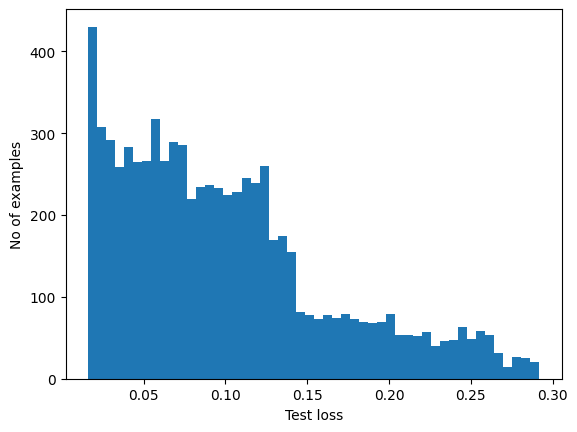

In [21]:
plt.hist(loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [26]:
preds = predict(autoencoder, test_df, 0.125)

In [27]:
list(preds).count(0),list(preds).count(1)

(5329, 2060)

# Submission


In [28]:
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/Data/answer_sample.csv')

In [29]:
submit['label'] = preds
submit.head()

,type,label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [30]:
submit.to_csv('./sub2023040616.csv', index=False)